<a href="https://colab.research.google.com/github/Mahfuz-rahman2002/Cats-vs-Dogs-classifier-using-grad-cam-and-transfer-learning/blob/main/cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 1: Prepare Directories
# ---------------------------
original_dataset_dir = '/content/drive/MyDrive/dogs vs cats'
base_dir = '/content/drive/MyDrive'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


In [ ]:
# Create directories if not exist
for label in ['cat', 'dog']:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)


In [ ]:
# 2. Split Data (80% train, 20% val)
# ---------------------------
split_ratio = 0.8

for label in ['cat', 'dog']:
    src_folder = os.path.join(original_dataset_dir, label)
    if not os.path.exists(src_folder):
        print(f"Error: Source directory not found: {src_folder}")
        continue

    images = os.listdir(src_folder)
    random.shuffle(images)

    split_point = int(len(images) * split_ratio)
    train_images = images[:split_point]
    val_images = images[split_point:]

    for img in train_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(train_dir, label, img))

    for img in val_images:
        shutil.copy(os.path.join(src_folder, img), os.path.join(val_dir, label, img))

print(" Dataset split into train and val sets.")

Error: Source directory not found: /content/drive/MyDrive/dogs vs cats/cat
Error: Source directory not found: /content/drive/MyDrive/dogs vs cats/dog
 Dataset split into train and val sets.


In [ ]:
# Step 2: Data Generators
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE),
                                           batch_size=BATCH_SIZE, class_mode='binary')
val_data = val_gen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE),
                                       batch_size=BATCH_SIZE, class_mode='binary')


Found 3156 images belonging to 4 classes.
Found 70 images belonging to 4 classes.


In [ ]:
# 4. Transfer Learning Model
# ---------------------------
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # freeze convolution layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# 5. Train the Model
# ---------------------------
EPOCHS = 5
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)


Epoch 1/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8554 - loss: 0.3683 - val_accuracy: 0.7857 - val_loss: 0.4798
Epoch 2/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 75s 743ms/step - accuracy: 0.9537 - loss: 0.1534 - val_accuracy: 0.8429 - val_loss: 0.3733
Epoch 3/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 678ms/step - accuracy: 0.9575 - loss: 0.1081 - val_accuracy: 0.8714 - val_loss: 0.2735
Epoch 4/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 862ms/step - accuracy: 0.9684 - loss: 0.0983 - val_accuracy: 0.8714 - val_loss: 0.2655
Epoch 5/5
99/99 ━━━━━━━━━━━━━━━━━━━━ 124s 679ms/step - accuracy: 0.9645 - loss: 0.0942 - val_accuracy: 0.8286 - val_loss: 0.3847


In [ ]:
# Step 5: Evaluate
# -----------------------------
loss, acc = model.evaluate(val_data)
print(f"\n📊 Accuracy: {acc*100:.2f}%, Loss: {loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.8166 - loss: 0.4239

📊 Accuracy: 82.86%, Loss: 0.3847


In [ ]:
# Step 6: Grad-CAM
# -----------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0), img

def show_gradcam(img_path, model, last_conv_layer_name="Conv_1"):
    img_array, original_img = preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction: Dog (68.90%)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_159']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


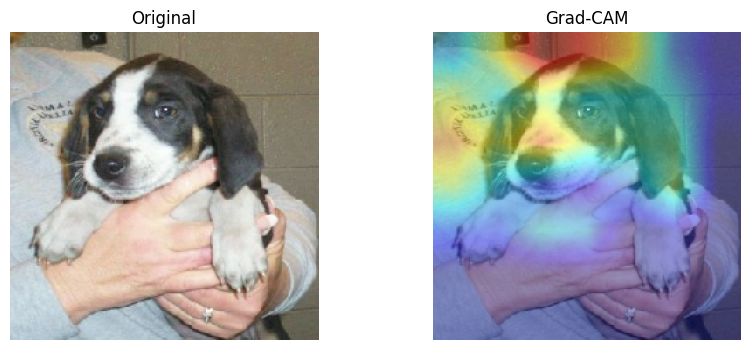

In [ ]:
# Step 7: Test a New Image
# -----------------------------
def test_image(img_path):
    img_array, img = preprocess_image(img_path)
    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    print(f"Prediction: {label} ({confidence*100:.2f}%)")
    show_gradcam(img_path, model)

# Example usage:
test_image("/content/drive/MyDrive/dogs vs cats/Dog/10.jpg")